In [1]:
import numpy as np
import pandas as pd
from collections import Counter

La fórmula de la Entropía

$$
H(p) = - \sum_i^m p_i * log_2\left| p_i \right|
$$

In [2]:
def H(p):
    return - np.sum(p * np.log2(p))

La fórmula del Gini (a medias)

$$
G(p) = \sum_i^m p_i^2
$$

In [3]:
def G(p):
    return np.sum(p**2)

La ganancia

$$
Gain(Y, F_j) = H(Y) - \sum_{f\hspace{1mm}\epsilon\hspace{1mm} val(F)} \frac{\left|Y_f\right|}{\left|Y\right|} * H(Y_f)
$$

Sin embargo por fines de implementación y velocidad, calculamos sólo el segúndo término de la ganancia $\sum_{f\hspace{1mm}\epsilon\hspace{1mm} val(F)} \frac{\left|Y_f\right|}{\left|Y\right|} * H(Y_f)$, ya la entropía total la calculamos al construir el modelo final.

In [4]:
def info_gain(X, Y, feature_index):
    gain = 0
    ggain = 0
    m = len(X)
    X_col = np.asanyarray(X)[:, feature_index]
    Y_col = np.asanyarray(Y)

    values = list(Counter(X_col).keys())

    for value in values:
        ##Extraemos los índices de las filas con el valor f en F
        indexes = np.where( X_col == value )
        targets_for_value = Y_col[indexes]
        
        ##Extraemos los números de elementos por cada valor de Y
        ##en la sub tabla con valores f en F
        count = Counter(targets_for_value)
        class_counts = np.asarray(list(count.values()))
        label_values_for_value = np.asarray(list(count.keys()))
        
        ##Número de filas con el valor f en F
        feature_counts = indexes[0].shape[0]
        #feature_counts = np.sum(class_counts)
        
        ##Entropía y Gini
        ##Mandamos los elementos usando el broadcasting de np
        ##dividiendo entre el número de entradas
        val_entropy = H(class_counts/feature_counts)
        val_gini = G(class_counts/feature_counts)

        gain += feature_counts/m * val_entropy
        ggain += feature_counts/m * val_gini
        
    return gain, 1-ggain

Construimos el árbol recursivamente respetando los tres casos dentro de las condicionales.

Calculamos la entropía completa al inicio de la función con la sub tabla correspondiente, y vamos restando los valores para el gain sólo si se debe entrar en la recursión.

In [5]:
def build(X, Y, featureNames):
    ## classes: Y
    ## data: X
    
    m = len(X)
    n = len(X[0])
    
    ##GET all target values of the actual node subset
    newY = list(Counter(Y).keys())
    
    #################################
    ##COUNT number of occurrencies of each target value
    ##Of the subset in that node and save it in 'freq'
    count_target_values = Counter(Y)
    freq = np.asarray([count_target_values[t] for t in newY])
    
    #Calculate entropy
    totalEntropy = H(freq/m)
    
    #Calculate gini
    totalGini = G(freq/m)
    totalGini = 1 - totalGini
    
    #Set default value as most repeated val
    default = Y[np.argmax(freq)]
    
    ##################################
    
    if m == 0 or n == 0:
        ##Rama Vacía
        return default
    elif len(Counter(Y)) == 1:
        #Si sólo queda un valor de targets retornamos ese valor
        return Y[0]
    else:
        ###################################
        
        gain = np.zeros(n)
        ggain = np.zeros(n)
        for feature in range(n): #n : nro de features
            ##Cada 'feature': es un índice así que son números
            
            ##AQUÍ RECIÉN RESTAMOS LA PARTE DE LA SUMATORIA DEL GAIN
            ##VALOR POR VALOR DE F A LA ENTROPÍA TOTAL.
            g, gg = info_gain(X, Y, feature)
            
            ##Guardamos el gain por cada F
            gain[feature] = totalEntropy - g
            ggain[feature] = totalGini - gg
            
        ##Agarramos el índice de la mejor feature F
        bestFeature_index = np.argmax(gain)
        #bestFeature_index = np.argmax(ggain)
        tree = {featureNames[bestFeature_index]: {}}

        #####################################
        
        X_arr = np.asanyarray(X)
        X_col = X_arr[:, bestFeature_index]
        Y_col = np.asanyarray(Y)
        
        ##Agarramos,los valores que puede tomar
        ##la mejor característica F.
        values = list(Counter(X_col).keys())

        #########################        
        for value in values:
            ##Índices de las filas con valor f en la feature F
            value_indexes = np.where(X_col == value)[0]

            ##Slice con todas las colúmnas menos la que hay que
            ##eliminar porque esa se está usando
            features_to_keep = np.arange(X_arr.shape[1])
            features_to_keep = np.delete(features_to_keep, bestFeature_index)

            X_new = X_arr[:, features_to_keep]
            X_new = X_new[value_indexes, :]
            
            ##newData: Nuevo 'X' con sólo las filas con valor f,
            ##pero eliminando la colúmna F
            newData = X_new.tolist()
            
            ##Los targets correspondientes con las colúmnas con
            ##valor f en F
            newClasses = Y_col[value_indexes].tolist()
            
            ##Las columnas a quedarse, lo mismo que features_to_keep
            ##pero con los nombres de colúmnas
            newNames = list(np.asanyarray(featureNames)[features_to_keep])

            ##Creamos el sub árbol.
            subtree = build(newData, newClasses, newNames)
            
            ##Guardamos sub el árbol.
            tree[featureNames[bestFeature_index]][value] = subtree
            
        return tree

In [32]:
#df = pd.read_csv('golf_dataset')
df = pd.read_csv('plans_dataset')
df.replace({False: 'false', True: 'true'}, inplace=True)
features = list(df)
X = df[features[:-1]].values.tolist()
Y = df[features[-1]].values.tolist()

In [33]:
Y

['Party',
 'Study',
 'Party',
 'Party',
 'Pub',
 'Party',
 'Study',
 'TV',
 'Party',
 'Study']

In [34]:
tree = build(X, Y, features)

In [35]:
tree

{'Party': {'Yes': 'Party',
  'No': {'Deadline': {'Urgent': 'Study',
    'None': 'Pub',
    'Near': {'Lazy': {'No': 'Study', 'Yes': 'TV'}}}}}}

In [18]:
def classify(tree, q, featureNames):

    if isinstance(tree, str):
        # Alcanzamos una hoja
        return tree
    else:
        a = list(tree.keys())[0]
        for i in range(len(featureNames)):
            if featureNames[i]==a:
                break
        
        try:
            t = tree[a][q[i]]
            return classify(t,q, featureNames)
        except:
            return None

In [20]:
q = np.asanyarray(X)[0, :].tolist()
print(q)
print( classify(tree, q, features) )

['overcast', 'hot', 'high', 'false']
yes


## Sklearn

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.feature_extraction import DictVectorizer
import pydotplus

In [22]:
vec = DictVectorizer()

In [23]:
X

[['overcast', 'hot', 'high', 'false'],
 ['overcast', 'cool', 'normal', 'true'],
 ['overcast', 'mild', 'high', 'true'],
 ['overcast', 'hot', 'normal', 'false'],
 ['rainy', 'mild', 'high', 'false'],
 ['rainy', 'cool', 'normal', 'false'],
 ['rainy', 'cool', 'normal', 'true'],
 ['rainy', 'mild', 'normal', 'false'],
 ['rainy', 'mild', 'high', 'true'],
 ['sunny', 'hot', 'high', 'false'],
 ['sunny', 'hot', 'high', 'true'],
 ['sunny', 'mild', 'high', 'false'],
 ['sunny', 'cool', 'normal', 'false'],
 ['sunny', 'mild', 'normal', 'true']]

In [24]:
features

['Outlook', 'Temperature', 'Humidity', 'Windy', 'Play']

In [25]:
sk_arr = df.values.copy()
sk_arr

array([['overcast', 'hot', 'high', 'false', 'yes'],
       ['overcast', 'cool', 'normal', 'true', 'yes'],
       ['overcast', 'mild', 'high', 'true', 'yes'],
       ['overcast', 'hot', 'normal', 'false', 'yes'],
       ['rainy', 'mild', 'high', 'false', 'yes'],
       ['rainy', 'cool', 'normal', 'false', 'yes'],
       ['rainy', 'cool', 'normal', 'true', 'no'],
       ['rainy', 'mild', 'normal', 'false', 'yes'],
       ['rainy', 'mild', 'high', 'true', 'no'],
       ['sunny', 'hot', 'high', 'false', 'no'],
       ['sunny', 'hot', 'high', 'true', 'no'],
       ['sunny', 'mild', 'high', 'false', 'no'],
       ['sunny', 'cool', 'normal', 'false', 'yes'],
       ['sunny', 'mild', 'normal', 'true', 'yes']], dtype=object)

In [26]:
X_arr = df.values
for col in range(X_arr.shape[1]):
    F = list(Counter(X_arr[:, col].tolist()).keys())
    for val, f in enumerate(F):
        #print(i, f)
        indexes = np.where(sk_arr == f)
        sk_arr[indexes] = val
sk_arr

array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 2, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [1, 2, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 2, 1, 0, 0],
       [1, 2, 0, 1, 1],
       [2, 0, 0, 0, 1],
       [2, 0, 0, 1, 1],
       [2, 2, 0, 0, 1],
       [2, 1, 1, 0, 0],
       [2, 2, 1, 1, 0]], dtype=object)

In [27]:
from sklearn.preprocessing import OneHotEncoder

In [28]:
X_list = []
for i in range(sk_arr.shape[1]):
    col = sk_arr[:, i].reshape(sk_arr.shape[0], 1)
    print(col)
    enc = OneHotEncoder()
    enc.fit(col)
    encoded = enc.transform(col).toarray()
    print()
    print(encoded)
    print(encoded.shape)
    X_list.append(encoded)
    print('_________________________________________________')
    
encoded_X = np.hstack(X_list)
print('FINAL ARRAY:', encoded_X.shape)
print(encoded_X)
print('------------------------------')
encoded_Y = encoded_X[:, -2:]
print(encoded_Y)
print('------------------------------')
encoded_X = encoded_X[:, :-2]
print(encoded_X)

[[0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]]

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
(14, 3)
_________________________________________________
[[0]
 [1]
 [2]
 [0]
 [2]
 [1]
 [1]
 [2]
 [2]
 [0]
 [0]
 [2]
 [1]
 [2]]

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
(14, 3)
_________________________________________________
[[0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]]

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
(14, 2)
_________________________________________________
[[0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]]

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 

In [29]:
dtree = DecisionTreeClassifier()
dtree.fit(encoded_X, encoded_Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

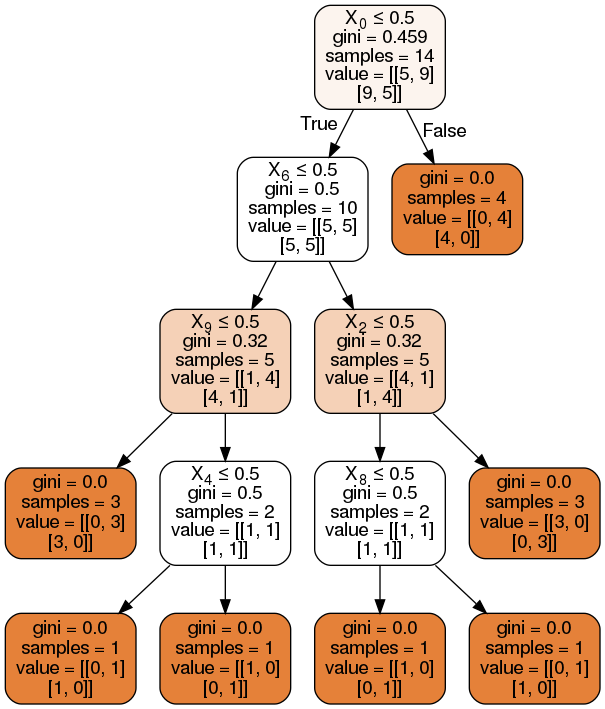

In [31]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())